In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import seaborn as sns

In [2]:
train_data = pd.read_csv('train_manual.csv')
test_data = pd.read_csv('test_manual.csv')

In [3]:
cat_features = []
features = [f for f in test_data if f not in ['id', 'Unnamed: 0']]
num_features = [f for f in features if f not in cat_features]

# Feature engineering

In [4]:
from dcor import distance_correlation

/home/notger/.local/share/virtualenvs/motley_crew_of_models-j78r5EOd/lib/python3.12/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(int64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(
/home/notger/.local/share/virtualenvs/motley_crew_of_models-j78r5EOd/lib/python3.12/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(int64, 1d, C), array(float64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(
/home/notger/.local/share/virtualenvs/motley_crew_of_models-j78r5EOd/lib/python3.12/site-packages/dcor/_fast_dcov_avl.py:554: UserWarn

Text(0.5, 1.0, 'DISTANCE correlations')

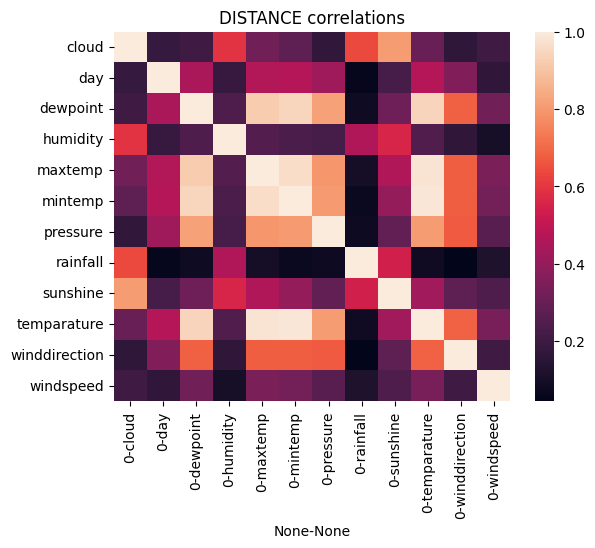

In [5]:
# Calculate the distance correlation for all feature combinations:
dc = {}
for feature_l in features + ['rainfall']:
    for feature_r in features + ['rainfall']:
        dc[(feature_l, feature_r)] = distance_correlation(train_data[feature_l], train_data[feature_r])

# Convert the dictionary into a dataframe and plot the heatmap:
fig = sns.heatmap(
    pd.DataFrame(
        list(dc.values()), 
        index=pd.MultiIndex.from_tuples(list(dc.keys()))
    ).unstack()
)
fig.set_title('DISTANCE correlations')

The strongest indicators seem to be sunshine, humidity and cloud coverage. Unsurprisingly.

Text(0.5, 1.0, 'LINEAR correlations')

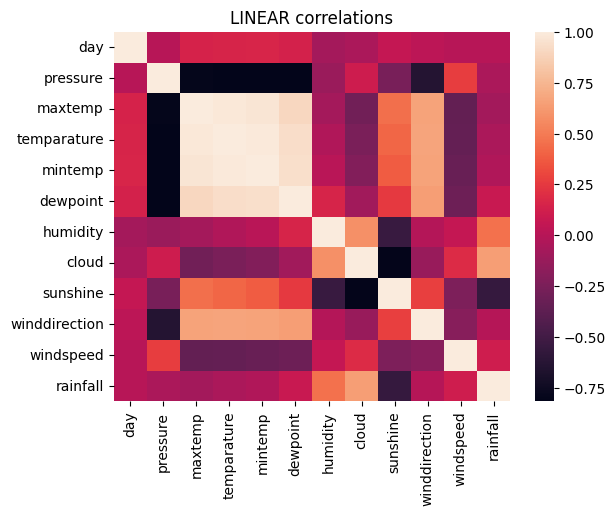

In [6]:
fig = sns.heatmap(
    train_data[features + ['rainfall']].corr()
)
fig.set_title('LINEAR correlations')

Again, unsurprisingly, more clouds and more humidity, less sunshine = more rainfall.

In [7]:
# Let's add a new feature, where we check for clouds + humidity and no sunshine
train_data['cloud_humidity_no_sun'] = train_data.cloud * train_data.humidity * (train_data.sunshine.max() - train_data.sunshine)
test_data['cloud_humidity_no_sun'] = test_data.cloud * test_data.humidity * (test_data.sunshine.max() - test_data.sunshine)

if 'cloud_humidity_no_sun' not in features:
    features += ['cloud_humidity_no_sun']

distance_correlation(train_data['cloud_humidity_no_sun'], train_data['rainfall'])

/home/notger/.local/share/virtualenvs/motley_crew_of_models-j78r5EOd/lib/python3.12/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float64, 1d, C), array(int64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


0.5781967728349737

# Training

In [8]:
X_train, X_validation, y_train, y_validation = train_test_split(train_data[[c for c in train_data if c in features]], train_data['rainfall'], train_size=0.75, random_state=42)

In [9]:
# If we don't want to use auto class weights, here are class weights:
class_weights = [int(len(train_data) - (train_data.rainfall == c).sum()) / len(train_data) for c in (0, 1)]

In [10]:
model = CatBoostClassifier(
    iterations=1000,
    custom_loss=[metrics.Logloss(), metrics. AUC()],
    eval_metric=metrics.AUC(),
    random_seed=42,
    logging_level='Silent',
    auto_class_weights='Balanced',  # Disable this, if you want to use class weights.
    #class_weights=class_weights,
    #od_type='Iter',
    #od_wait=50,
)

In [11]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    plot=True,
    use_best_model=True,
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [12]:
# Retrain with full dataset:

In [13]:
iteration_count = model.best_iteration_

In [14]:
model = CatBoostClassifier(
    iterations=int(iteration_count * 1.3),
    custom_loss=[metrics.AUC(), metrics.Accuracy(), metrics.Precision()],
    random_seed=42,
    logging_level='Silent',
    auto_class_weights='Balanced',  # Disable this, if you want to use class weights.
    #class_weights=class_weights,    
)

In [15]:
model.fit(
    train_data[features], train_data.rainfall,
    cat_features=cat_features,
    plot=True,
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [16]:
pd.DataFrame(model.predict_proba(test_data)[:, 1], columns=['rainfall']).join(test_data.id).set_index('id', drop=True).to_csv('submission_catboost.csv')